In [ ]:
!pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import tensorflow as tf
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

<ipython-input-1-fdf713827114>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
tfd = tfp.distributions
tfpl = tfp.layers
ds = tfp.distributions
train_buff= 64000
batch_size= 64
test_buff=  10240
shape = (28,28,1)
# Чтение данных, разделение обучающих и тестовых данных
x_train_size, x_test_size = int(train_buff/ batch_size), int(test_buff/batch_size)
(x_train_images, _), (x_test_images, _) = tf.keras.datasets.mnist.load_data()
x_train_images = x_train_images.reshape(x_train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
x_test_images = x_test_images.reshape(x_test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train_images)
    .shuffle(train_buff)
    .batch(batch_size)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(x_test_images)
    .shuffle(test_buff)
    .batch(batch_size)
)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
class VAEGAN(tf.keras.Model):
    """Инициализация модели VAEGAN.

    Аргументы:
    - kwargs: словарь с параметрами модели

    Атрибуты:
    - enc: кодировщик модели
    - dec: декодировщик модели
    - disc: дискриминатор модели
    - D_prop: значение D_prop (вероятность быть реальным)
    - enc_optimizer: оптимизатор для обновления параметров кодировщика
    - dec_optimizer: оптимизатор для обновления параметров декодировщика
    - disc_optimizer: оптимизатор для обновления параметров дискриминатора
    """

    def __init__(self, **kwargs):
        super(VAEGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = Sequential(self.enc)
        self.dec = Sequential(self.dec)
        inputs, disc_l, outputs = self.vae_disc_function()
        self.disc = Model(inputs=[inputs], outputs=[outputs, disc_l])
        self.D_prop = 1
        self.enc_optimizer = Adam(self.lr_base_gen, beta_1=0.5)
        self.dec_optimizer = Adam(self.lr_base_gen, beta_1=0.5)
        self.disc_optimizer = Adam(self.get_lr_d, beta_1=0.5)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return mu, sigma

    def dist_encode(self, x):
        mu, sigma = self.encode(x)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def get_lr_d(self):
        return self.lr_base_disc * self.D_prop

    def decode(self, z):
        return self.dec(z)

    def discriminate(self, x):
        return self.disc(x)

    def reconstruct(self, x):
        mean, _ = self.encode(x)
        return self.decode(mean)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    #  Вычисление  потери
    def compute_loss(self, x):
        """Аргументы:
    - x: входные данные
       Возвращение значений потерь D_prop, latent_loss, discrim_layer_recon_loss, gen_fake_loss, disc_fake_loss, disc_real_loss.
     - D_prop: - значение D_prop (вероятность быть реальным), которое вычисляется с помощью сигмоидной функции.
     - latent_loss: - потеря отклонения KL-дивергенции, которая вычисляется на основе расхождения между распределением q(z) (кодирующим распределением)
     и априорным распределением p(z) (априорным распределением).
     - discrim_layer_recon_loss:- потеря восстановления для слоев дискриминатора.
     - gen_fake_loss: - потеря генератора, рассматриваемая как потеря для сгенерированных данных, принимаемых за реальные
     - disc_fake_loss: - потеря дискриминатора для сгенерированных данных.
     - disc_real_loss: - потеря дискриминатора для реальных данных.
     """
        q_z = self.dist_encode(x)
        z = q_z.sample()
        p_z = ds.MultivariateNormalDiag(
            loc=[0.0] * z.shape[-1], scale_diag=[1.0] * z.shape[-1]
        )
        xg = self.decode(z)
        z_samp = tf.random.normal([x.shape[0], 1, 1, z.shape[-1]])
        xg_samp = self.decode(z_samp)
        d_xg, ld_xg = self.discriminate(xg)
        d_x, ld_x = self.discriminate(x)
        d_xg_samp, ld_xg_samp = self.discriminate(xg_samp)
        disc_real_loss = gan_loss(logits=d_x, is_real=True)
        disc_fake_loss = gan_loss(logits=d_xg_samp, is_real=False)
        gen_fake_loss = gan_loss(logits=d_xg_samp, is_real=True)

        discrim_layer_recon_loss = (
            tf.reduce_mean(tf.reduce_mean(tf.math.square(ld_x - ld_xg), axis=0))
            / self.recon_loss_div
        )

        self.D_prop = sigmoid(
            disc_fake_loss - gen_fake_loss, shift=0.0, mult=self.sig_mult
        )

        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0)) / self.latent_loss_div

        return (
            self.D_prop,
            latent_loss,
            discrim_layer_recon_loss,
            gen_fake_loss,
            disc_fake_loss,
            disc_real_loss,
        )

    # @tf.function
    def compute_gradients(self, x):
        """Вычисление градиентов для обновления параметров модели.

        Аргументы:
        - x: входные данные

        Возвращает:
        - enc_gradients: градиенты для обновления параметров кодировщика
        - dec_gradients: градиенты для обновления параметров декодировщика
        - disc_gradients: градиенты для обновления параметров дискриминатора
        """
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            (
                _,
                latent_loss,
                discrim_layer_recon_loss,
                gen_fake_loss,
                disc_fake_loss,
                disc_real_loss,
            ) = self.compute_loss(x)

            enc_loss = latent_loss + discrim_layer_recon_loss
            dec_loss = gen_fake_loss + discrim_layer_recon_loss
            disc_loss = disc_fake_loss + disc_real_loss

        enc_gradients = enc_tape.gradient(enc_loss, self.enc.trainable_variables)
        dec_gradients = dec_tape.gradient(dec_loss, self.dec.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return enc_gradients, dec_gradients, disc_gradients

    @tf.function
    def apply_gradients(self, enc_gradients, dec_gradients, disc_gradients):
        self.enc_optimizer.apply_gradients(
            zip(enc_gradients, self.enc.trainable_variables)
        )
        self.dec_optimizer.apply_gradients(
            zip(dec_gradients, self.dec.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def train(self, x):
        enc_gradients, dec_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients(enc_gradients, dec_gradients, disc_gradients)
def gan_loss(logits, is_real=True):
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


def sigmoid(x, shift=0.0, mult=20):
    return tf.constant(1.0) / (
        tf.constant(1.0) + tf.exp(-tf.constant(1.0) * (x * mult))
    )

In [ ]:
encoder = [
    tf.keras.layers.InputLayer(input_shape=shape),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 128*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

def vaegan_discrim():
    """Определение архитектуры дискриминатора модели VAEGAN.
    Возвращает:
    - inputs: входной тензор модели
    - lastlayer: последний слой перед выходом
    - outputs: выходной тензор модели
    """
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    conv1 = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation="relu"
            )(inputs)
    conv2 = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation="relu"
            )(conv1)
    flatten = Flatten()(conv2)
    lastlayer = Dense(units=512, activation="relu")(flatten)
    outputs = Dense(units=1, activation=None)(lastlayer)
    return inputs, lastlayer, outputs

gen_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-3)

In [ ]:
model = VAEGAN(
            enc = encoder,
            dec = decoder,
            vae_disc_function = vaegan_discrim,
            lr_base_gen = 1e-3, # базовая скорость обучения для генератора
            lr_base_disc = 1e-4, # задача дискриминатора проще, чем у генераторов, поэтому скорость обучения ниже
            latent_loss_div=1, # этот параметр позволит достичь значений потери близких к ~1-10
            sig_mult = 10, # насколько сжимается скорость обучения дискриминатора (используется сигмоидная функция)
            recon_loss_div = .001, # этот параметр позволит достичь значений потери близких к ~1-10
            )
N_Z = 128

input_data = next(iter(train_dataset))
model.train(input_data)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def plot_reconstruction(model, input_data, nex=8, zm=2, epoch=None, save_dir=None):

    """Визуализация реконструкции данных с использованием модели.
    Аргументы:
    - model: модель VAEGAN
    - input_data: входные данные для визуализации
    - nex: количество примеров для отображения в каждой строке
    - zm: масштаб фигуры
    - epoch: номер эпохи

    Возвращает:
    - None (отображает график)
     """
    reconstructed_data = model.reconstruct(input_data)
    samples = model.decode(tf.random.normal(shape=(batch_size, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (data, label) in enumerate(
        zip(
            [input_data, reconstructed_data, samples],
            ["input_data", "reconstructed_data", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                data.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(label)

    if epoch is not None and save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, f"reconstruction_epoch_{epoch}.png"))

    plt.show()

In [ ]:
def plot_losses(losses, epoch=None, save_dir=None):
    """Аргументы:
    - losses: таблица с значениями потерь

    Возвращает:
    - None (отображает график)
    """
    fig, axs =plt.subplots(ncols = 4, nrows = 1, figsize= (16,4))
    axs[0].plot(losses.latent_loss.values, label = 'Потеря скрытого представления')
    axs[1].plot(losses.discrim_layer_recon_loss.values, label = 'Потеря слоя дискриминатора')
    axs[2].plot(losses.disc_real_loss.values, label = 'Потеря дискриминатора (реальные данные)')
    axs[2].plot(losses.disc_fake_loss.values, label = 'Потеря дискриминатора (сгенерированные данные)')
    axs[2].plot(losses.gen_fake_loss.values, label = 'Потеря генератора (сгенерированные данные)')
    axs[3].plot(losses.d_prop.values, label = 'D_prop')

    for ax in axs.flatten():
        ax.legend()
    if epoch is not None and save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, f"losses_epoch_{epoch}.png"))
    plt.show()

In [ ]:
losses = pd.DataFrame(columns=[
    'd_prop',
    'latent_loss',
    'discrim_layer_recon_loss',
    'gen_fake_loss',
    'disc_fake_loss',
    'disc_real_loss',
])

Epoch: 14


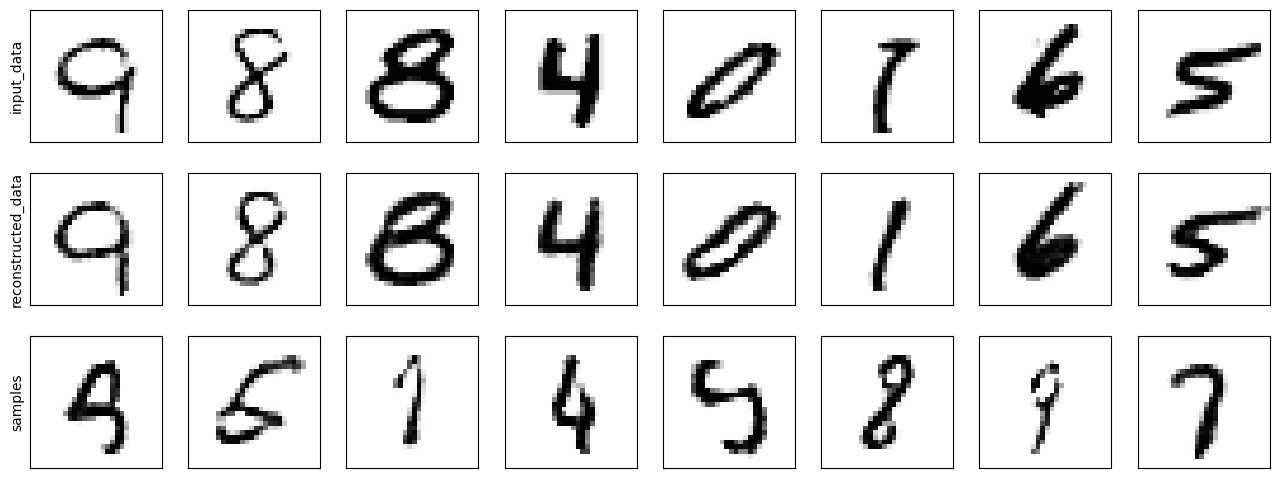

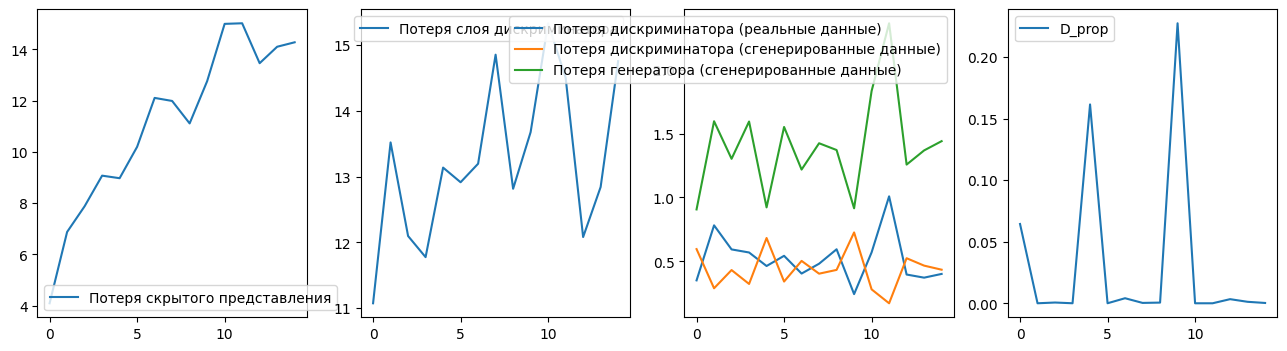

          d_prop  latent_loss  discrim_layer_recon_loss  gen_fake_loss  \
0   6.443575e-02     4.094525                 11.074044       0.906176   
1   5.292499e-06     6.877442                 13.518191       1.596080   
2   6.114378e-04     7.880248                 12.095942       1.302230   
3   1.530936e-05     9.075326                 11.775152       1.593871   
4   1.615950e-01     8.975423                 13.135707       0.922062   
5   1.889690e-05    10.200164                 12.913130       1.551266   
6   4.107574e-03    12.109251                 13.194506       1.218000   
7   3.015524e-04    11.990265                 14.851288       1.423913   
8   5.523775e-04    11.113559                 12.814145       1.370863   
9   2.275412e-01    12.761720                 13.674446       0.915002   
10  8.688124e-07    14.998799                 15.328685       1.832522   
11  2.198740e-09    15.021563                 14.503383       2.362596   
12  3.345210e-03    13.463758         

In [ ]:
n_epochs = 15
save_dir = "/content/drive/MyDrive/VAEGAN"

for epoch in range(n_epochs):
    for batch, x_train in tqdm(
        zip(range(x_train_size), train_dataset), total=x_train_size
    ):
        model.train(x_train)
    loss = []
    for batch, x_test in tqdm(
        zip(range(x_test_size), train_dataset), total=x_test_size
    ):
        loss.append(model.compute_loss(x_train))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print("Epoch: {}".format(epoch))
    plot_reconstruction(model, input_data, epoch=epoch, save_dir=save_dir)
    plot_losses(losses, epoch=epoch, save_dir=save_dir)
    print(losses)

In [ ]:
print(losses)

          d_prop  latent_loss  discrim_layer_recon_loss  gen_fake_loss  \
0   6.443575e-02     4.094525                 11.074044       0.906176   
1   5.292499e-06     6.877442                 13.518191       1.596080   
2   6.114378e-04     7.880248                 12.095942       1.302230   
3   1.530936e-05     9.075326                 11.775152       1.593871   
4   1.615950e-01     8.975423                 13.135707       0.922062   
5   1.889690e-05    10.200164                 12.913130       1.551266   
6   4.107574e-03    12.109251                 13.194506       1.218000   
7   3.015524e-04    11.990265                 14.851288       1.423913   
8   5.523775e-04    11.113559                 12.814145       1.370863   
9   2.275412e-01    12.761720                 13.674446       0.915002   
10  8.688124e-07    14.998799                 15.328685       1.832522   
11  2.198740e-09    15.021563                 14.503383       2.362596   
12  3.345210e-03    13.463758         